In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import numpy as np


In [5]:
import logging

# Set logging level to WARNING or ERROR
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)



In [7]:
data_path = '../../dataset/Synthetic_Cardiovascular.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}") 

Mean Squared Error: 11.35


Global SHAP Score:


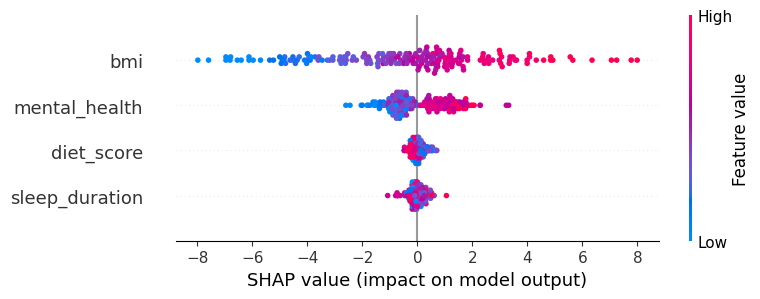

Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.1952
Column 1: 0.1945
Column 2: 2.3926
Column 3: 0.9062


In [9]:
# Tree SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
shap.summary_plot(shap_values, X_test)

column_averages = np.mean(np.abs(shap_values), axis=0)

print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

100%|██████████| 200/200 [00:18<00:00, 11.07it/s]


Global SHAP Score:


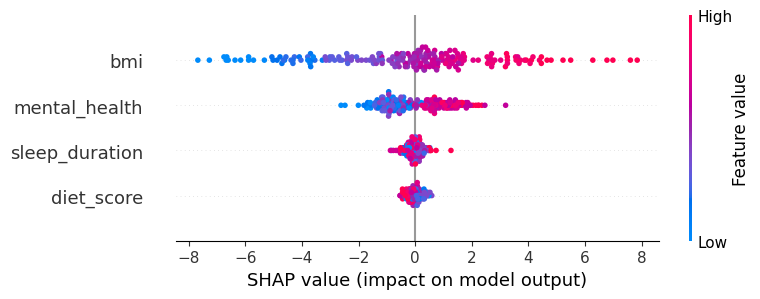

Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.1919
Column 1: 0.2053
Column 2: 2.2861
Column 3: 0.9642


In [8]:
# Kernel SHAP
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
shap_values = explainer.shap_values(X_test)

print("Global SHAP Score:")
shap.summary_plot(shap_values, X_test)

column_averages = np.mean(np.abs(shap_values), axis=0)

print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x0000026EE51E8350>


Global SHAP Score:


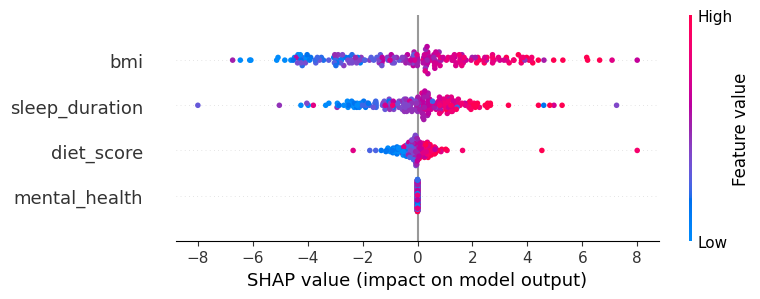

None
Index(['diet_score', 'sleep_duration', 'bmi', 'mental_health'], dtype='object')
Average values for each column:
Column 0: 0.4426
Column 1: 1.3368
Column 2: 2.2806
Column 3: 0.0000


In [24]:
# Causal SHAP
import pickle

file_path = '../../result/Synthetic_Cardiovascular/Causal_SHAP_CV_42_Dec.pkl'
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

data_path = '../../dataset/Synthetic_Cardiovascular.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()

causal_shap_values = load_and_format_shap_values(file_path, feature_names)
causal_shap_values = np.clip(causal_shap_values, -8, 8)  

print("Global SHAP Score:")
print(shap.summary_plot(causal_shap_values, X_test))

column_averages = np.mean(np.abs(causal_shap_values), axis=0)
print(X_test.columns)
print("Average values for each column:")
for i, avg in enumerate(column_averages):
    print(f"Column {i}: {avg:.4f}")